In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

nltk.download('punkt')
nltk.download('wordnet') 
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords 
from scipy.spatial.distance import cdist 
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc


class tweet():
    
    # Charger les donnees
    def _load_data(self, url_data):
        self.data = pd.read_csv(url_data)
        
    # constructeur     
    def __init__(self, load_ds):
        self._load_data(load_ds)
    
    # supprimer les colonnes 
    def delete_column(self, column):
        self.data = self.data.drop(columns ,axis=1)
        
    # Pre-traitment:
    # changer les mots en miniscules 
    # Application tokinization
    # Application Stemming
    def preprocessing(self):
        # to lower case 
        self.data['text'] = [ e.lower() for e in self.data['text'] ]
        # tokonize
        self.data['text'] = [ word_tokenize(i) for i in self.data['text'] ]
    
        bag_word = []
        for i,e in enumerate( self.data['text'] ):
            list_words = []
            ps = PorterStemmer()
            for word, tag in pos_tag(e):
                if word not in stopwords.words('english') and word.isalpha():
                    # word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                    word_Final = ps.stem(word)
                    list_words.append(word_Final)                   
            self.data.loc[i,'text_final'] = str(list_words) 
    
    # TF-IDF
    def apply_tf_idf(self):
        tf=TfidfVectorizer()
        text_tf= tf.fit_transform(self.data['text_final'])
        self.new_data = pd.DataFrame(text_tf.toarray(), columns=tf.get_feature_names())       
        return self.new_data

    # ACP 
    def apply_acp(self,nb):
        pca = PCA( n_components = nb )
        principalComponents = pca.fit_transform(self.new_data) 
        columns = []
        for i in range(nb):
            name_column = "component_"+str(i)
            columns.append(name_column)
            
        self.principalDf = pd.DataFrame( data = principalComponents, columns = columns )
        self.data["airline_sentiment"] = self.data["airline_sentiment"].map({"negative": 0, "neutral": 1, "positive":2}) 
        y_ =  self.data["airline_sentiment"]
        self.principalDf = pd.concat([self.principalDf, y_ ], axis = 1)
        return self.principalDf
    
    # split data pour K-means
    def  split_data_set(self):       
        self.X_train, self.X_test = train_test_split(self.principalDf,test_size=0.3, random_state=123)       
        
    
    # Trouver le nb de cluster optimal 
    def find_optimal_K_elbow_method(self, start, end):
        wcss = []
        for i in range(start, end):
            kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
            kmeans.fit(self.X_train)
            wcss.append(kmeans.inertia_) # 
        plt.plot(range(start, end), wcss)
        plt.title('Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        plt.show()
    
    # Application algorithme K-means
    def Kmeans(self,nb_k):
               
        kmeans = KMeans(n_clusters=nb_k, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit( self.X_train )
        y_labels_train = kmeans.labels_    
        y_labels_test = kmeans.predict(self.X_test)        
        self.X_train['nouveau_cible_airline_sentiment'] = y_labels_train
        self.X_test['nouveau_cible_airline_sentiment'] = y_labels_test
        # joindre les deux dataset X_train and X_test 
        self.df_apre_kmeans = pd.concat([ self.X_train, self.X_test ])
        
        return self
    
    # comparaison entre apres et avant application de Kmeans sous forme d'un plot line 
    def comparer_scores(self):       
        line_chart1 = plt.plot(range(0,10), self.scores_avant_kmeans)
        line_chart2 = plt.plot(range(0,10), self.scores_apres_kmeans )
        plt.title('comparaison entre apres et avant application Kmeans ')
        plt.xlabel('Iteration')
        plt.ylabel('Score')
        plt.legend(['Avant Kmeans', 'Apres Kmeans'], loc=4)
        plt.show()
    
    # Classification 
    def classify(self, etat_application_kmeans = False):
        seed = 123
        i = 0
        model = LogisticRegression()                
        kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=seed)        
        # avant l'application de Kmeans
        if etat_application_kmeans == False :
            self.scores_avant_kmeans = []            
            X = self.principalDf.drop(["airline_sentiment"], axis=1)
            Y = self.principalDf["airline_sentiment"]            
        # apres l'application Kmeans
        if etat_application_kmeans == True :
            self.scores_apres_kmeans = []
            X = self.df_apre_kmeans.drop(["nouveau_cible_airline_sentiment","airline_sentiment"], axis=1)
            Y = self.df_apre_kmeans["nouveau_cible_airline_sentiment"]                
        for train_index,test_index in kf.split(X, Y):
            print('{} de  KFold {}'.format(i,kf.n_splits))
            x_train,x_test = X.loc[train_index],X.loc[test_index]
            y_train,y_test = Y.loc[train_index],Y.loc[test_index]
            #model            
            lr = LogisticRegression()
            lr.fit(x_train,y_train)          
            score = lr.score(x_test,y_test)             
            print('score:',score)
            if etat_application_kmeans == False:
                self.scores_avant_kmeans.append(score)            
            if etat_application_kmeans == True :
                self.scores_apres_kmeans.append(score)                
            i = i + 1    

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno -3] Temporary failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


## Instance class Tweet 

In [3]:
tweets = tweet("../input/Tweets.csv")

### Supprimer les colonnes

In [4]:
columns = ["negativereason_gold","airline_sentiment_gold","tweet_coord", "user_timezone","tweet_location", "tweet_created", "retweet_count","negativereason_confidence","negativereason_confidence", "negativereason","airline_sentiment_confidence","name", "airline"]
tweets.delete_column(columns)

## Pre-traitement 

In [5]:
tweets.preprocessing()

## Application TF-IDF

In [6]:
tweets.apply_tf_idf()

,aa,aaaand,aaadvantag,aaalwaysl,aacustomerservic,aadavantag,aadelay,aadv,aadvantag,aafail,...,zfv,zip,zipper,zkatcher,zombi,zone,zoom,zrh,zuke,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Application ACP

In [7]:
# nombre de composant = 1357
tweets.apply_acp(1357)

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,...,component_1348,component_1349,component_1350,component_1351,component_1352,component_1353,component_1354,component_1355,component_1356,airline_sentiment
0,-0.019800,0.053762,0.034098,-0.028996,0.015997,0.018017,-0.028594,-0.006084,-0.077186,-0.015482,...,0.002459,0.000120,-0.001014,0.003159,0.002172,0.001948,-0.000156,0.003689,0.000701,1
1,-0.018224,0.053587,0.038331,-0.025674,0.019646,0.011570,-0.026985,0.009515,-0.073037,-0.023610,...,0.008440,-0.001771,-0.005428,-0.005511,-0.008784,-0.009202,0.004868,0.005884,0.001829,2
2,-0.041067,0.021659,0.023981,-0.018847,0.023881,0.013083,-0.027862,-0.004981,-0.065949,0.016709,...,0.004338,0.004648,0.002332,0.002408,-0.000620,0.001776,-0.005168,0.003056,-0.003820,1
3,-0.023253,0.048003,0.031540,-0.025379,0.015224,0.011551,-0.024911,-0.003888,-0.052618,-0.015883,...,-0.011660,0.012603,-0.007874,0.008093,0.017903,0.065635,0.013026,0.000319,0.018749,0
4,-0.020596,0.058818,0.037434,-0.032745,0.017668,0.020164,-0.035352,0.005943,-0.081703,-0.027493,...,0.003957,0.001097,-0.004210,-0.007171,0.000533,0.001586,-0.005153,-0.000816,-0.002309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,0.208082,-0.215686,-0.149916,0.019228,-0.063583,0.143839,0.015001,-0.000576,-0.045861,-0.068684,...,0.001537,-0.000107,-0.001418,0.000344,-0.001997,0.000143,-0.005457,-0.003177,-0.003267,2
14636,-0.097992,-0.115721,-0.088840,0.019920,-0.055768,0.043567,0.012411,0.089945,0.071104,-0.058060,...,-0.014052,-0.005365,-0.045653,-0.007110,-0.020808,-0.005054,-0.007358,0.010392,-0.046458,0
14637,-0.017333,-0.006776,0.003817,-0.111420,-0.037186,0.187699,0.018792,-0.010604,-0.064016,0.037444,...,0.001853,0.000799,0.004965,0.001818,-0.000462,-0.000299,0.003015,-0.008188,-0.004325,1
14638,-0.066465,-0.079018,-0.070547,-0.029778,-0.044610,0.110459,0.001854,-0.003935,-0.003539,0.005572,...,0.015639,-0.000291,0.032999,0.010684,-0.022824,-0.017675,0.001769,0.012672,0.009580,0


## Classification avec LogisticRegression avant l'application de k-means

In [8]:
tweets.classify()

0 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.8088737201365188
1 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.78839590443686
2 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.7863481228668942
3 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.7950819672131147
4 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.7759562841530054
5 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.7739071038251366
6 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.7745901639344263
7 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.7848360655737705
8 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.7778537252221462
9 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.792749658002736


## Split dataset pour Application K-means

In [9]:
tweets.split_data_set()

## Le nombre optimal de cluster

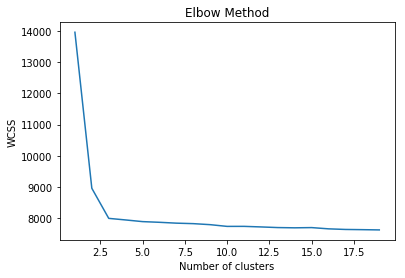

In [10]:
tweets.find_optimal_K_elbow_method(1,20)

## Application Algorithm Kmeans

In [11]:
tweets.Kmeans(3)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Classification avec LogisticRegression apres l'application de k-means

In [12]:
# classification apres l'application de Kmeans
tweets.classify(True)

0 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.8
1 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.78839590443686
2 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.7726962457337884
3 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.7773224043715847
4 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.7848360655737705
5 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.7773224043715847
6 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.787568306010929
7 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.7930327868852459
8 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.7566643882433356
9 de  KFold 10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


score: 0.7879616963064295


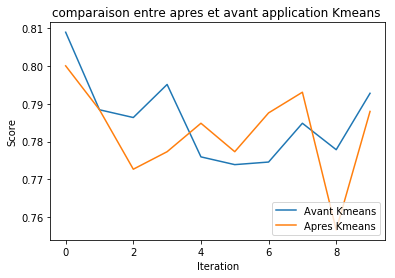

In [13]:
tweets.comparer_scores()